## Analysis of stock prices using PCA / Notebook 1

In this take-home final you are to analyze the daily changes in stock prices using PCA and to mesure the dimension of stock sequences.

We Start by downloading data and pre-processing it to make it ready for analysis using Spark.

In [1]:
import sys,os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import pandas as pd
from glob import glob
import pickle


### Stock Info
The Pickle file `Tickers.pkl` contains information about the stocks in the SP500.

* `TickerInfo` - a pandas table that stores the name, sector, and sector ID for 505 stocks
* `Tickers` - A list of the stocks that we are going to analyze (each student should eliminate a few of these stocks before doing their analysis)


In [2]:
!ls

1.Prepare daily ratio file to be read as spark Dataframe.ipynb	data
2.Dimensionality.ipynb						figs
3.PCA of stocks using Spark.ipynb				Final-Email.txt
4.Classify Stocks .ipynb					lib


In [3]:
D=pickle.load(open('data/Tickers.pkl','rb'))
TickerInfo=D['TickerInfo']
Tickers=D['Tickers']
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}

In [4]:
TickerInfo.head()

,Ticker,Name,Sector,SECTOR_ID
0,MMM,3M|3M Company,Industrials,INDS
1,ABT,Abbott Laboratories,Health Care,HC
2,ABBV,AbbVie Inc.,Health Care,HC
3,ACN,Accenture plc,Information Technology,IT
4,ATVI,Activision Blizzard,Information Technology,IT


### Differences between the stocks lists
In the following you will work with three different sets of stocks:

1. The stocks listed in `TickerInfo`
2. The stocks listed in `Tickers`
3. The stock files that you will download from S3.

* The stocks you will analyze are those in `Tickers` less the one that you were instructed to remove.
* The Files you will download contain all of the stocks in `Tickers` plus a few stocks that are skipped because they are outliers.
* The Stocks in `TickerInfo` include most of the stocks in `Tickers`, but there are a few missing. When we will represent each stock with its `SECTOR_ID` these stocks will be represented by their Ticker.

In [5]:
len(Tickers),len(TickerInfo)

(481, 505)

### Stock and sector information
`TickerInfo` is a pandas table containing, for each Ticker, the company name, the sector, and a sector ID. There are 11 sectors. Some, such as `Consumer Discretionary` and `Information Technology` include many stocks while others, such as `Telecommunication Services` include very few.

In [6]:
from collections import Counter
L=list(Counter(TickerInfo['Sector']).items())
print('Sector ID\t\tSector Name\tNo. of Stocks')
print('=========\t\t===========\t=============')
for l in L:
    print('%s\t%30s\t%d'%(Sectors[l[0]],l[0],l[1]))

Sector ID		Sector Name	No. of Stocks
=========		===========	=============
INDS	                   Industrials	66
HC	                   Health Care	60
IT	        Information Technology	70
CD	        Consumer Discretionary	84
UTIL	                     Utilities	28
FIN	                    Financials	66
MAT	                     Materials	25
RE	                   Real Estate	31
CS	              Consumer Staples	37
EN	                        Energy	34
TS	    Telecommunication Services	4


### Download Data
The data is a directory with .csv files, one for each stock. This directory has been tarred and uploaded to 
S3, at: https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz

Download and untar the file to create a subdirectory of the current directory called `spdata_csv`

In [7]:
!wget https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz

--2018-06-01 05:12:59--  https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz
Resolving mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)... 52.218.200.66
Connecting to mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)|52.218.200.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109237346 (104M) [application/octet-stream]
Saving to: ‘spdata_csv.tgz’

spdata_csv.tgz      100%[===================>] 104.18M  8.39MB/s    in 15s     

2018-06-01 05:13:14 (7.09 MB/s) - ‘spdata_csv.tgz’ saved [109237346/109237346]

--2018-06-01 05:13:14--  http://data/spdata_csv.tgz
Resolving data (data)... failed: Name or service not known.
wget: unable to resolve host address ‘data’
FINISHED --2018-06-01 05:13:14--
Total wall clock time: 15s
Downloaded: 1 files, 104M in 15s (7.09 MB/s)


In [9]:
!tar xzf spdata_csv.tgz
!rm spdata_csv/._*
!ls -1 spdata_csv/ | wc

    485     485    3895


In [10]:
#change this path to where you stored the raw data   #del Cell
Data_dir='./spdata_csv/'  #del
curr_dir=os.getcwd()      #del
curr_dir                  #del


'/home/jovyan/work/HW2018/Final'

## Read Data and create a single table

Your task in this notebook is to read the sock-information `.csv` files, extract from them the column 
`Adj. Open` and combine them into a single `.csv` file containing all of the information that is relevant for later analysis.

Below we suggest a particular sequence of steps, you can either follow these steps, or do this in your own way.  The end result should be a file called `SP500.csv` which stores the information described below.

### Step 1: files into pandas dataframes

In this step you read all of the relevant information into a large dictionary we call `Tables`.

The key to this dictionary is the stocks "ticker" which corresponds to the file name excluding the `.csv` extension.

You should read in all of the files in the directory `spdata_csv` other than:

* Files for tickers that are not in the list `Tickers`.
* Files for tickers that were listed in the email you got for this final.
As part of the email you got about this final, there is a list of tickers that you should omit from your analysis.

In [11]:
Tables={}
#del the rest of this cell
%cd spdata_csv/
for filename in glob('*.csv'):
    code = filename[:-4]
    if not code in Tickers:
        print('skipping ',code)
        continue
    tbl=pd.read_csv(filename,index_col='Date',parse_dates=True)
    if(np.shape(tbl)[1]==12):
        Tables[code]=tbl.sort_index()
        Tables[code]
    else:
        print(filename,np.shape(tbl))

%cd ..

/home/jovyan/work/HW2018/Final/spdata_csv
skipping  LIFE
skipping  HAS
skipping  UNM
skipping  PGR
/home/jovyan/work/HW2018/Final


In [12]:
# Example of an entry in `Tables`
Tables['IBM'].head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1962-01-02,578.5,578.5,572.0,572.00,5162.666667,0.0,1.0,5.180989,5.180989,5.122776,5.122776,387200.0
1962-01-03,572.0,577.0,572.0,577.00,3840.000000,0.0,1.0,5.122776,5.167555,5.122776,5.167555,288000.0
1962-01-04,577.0,577.0,571.0,571.25,3413.333333,0.0,1.0,5.167555,5.167555,5.113820,5.116059,256000.0
1962-01-05,570.5,570.5,559.0,560.00,4842.666667,0.0,1.0,5.109342,5.109342,5.006349,5.015305,363200.0
1962-01-08,559.5,559.5,545.0,549.50,7253.333333,0.0,1.0,5.010827,5.010827,4.880966,4.921268,544000.0


### Step 2: Computing diffs and combining into a single table

The next step is to extract from each table the relevant prices, compute an additional quantity we call `diff` and create a single combined pandas dataframe.

The price we ue is the **Adjusted Open Price** which is the price when the stock exchange opens in the morning. We use the **adjusted** price which eliminates technical adjustments such as stock splits.

It is more meaningful to predict *changes* in prices than prices themselves. We therefor compute for each stock a `Diffs` sequence in which $d(t)=\log \frac{p(t+1)}{p(t)}$ where $p(t)$ is the price at time $t$ and $d(t)$ is the price diff or the price ratio.

Obviously, if we have a price sequence of length $T$ then the length of the diff sequence will be $T-1$. To make the price sequence and the diff sequence have the same length we eliminate the last day price for each sequence.

Your task in this step is to join the stock tables by date, compute the diff seqeunce, and create one large Pandas DataFrame where the row index is the date, and there are two columns for each ticker. For example for the ticker `IBM`, there would be two columns `IBM_P` and `IBM_D`. The first corresponds to the prices of the IBM stock $p(t)$ and the second to the price difference $d(t)$

In [13]:
Diffs=pd.DataFrame()
#remove below
Indices=set(Tables.keys())
# Remove the following lines to process all stocks. Plot the PCA and the time sequences of these stocks 
# to see why they are outliers and need to be removed.
Indices=Indices - set(['LIFE', 'PGR', 'HAS','UNM'])  #remove outlier stock - most likely due to file errors
print(len(Indices))
i=1
for code in Indices:
    print('\r',i,code, end=' ')
    i+=1
    tbl=Tables[code]
    S=tbl['Adj. Open']
    prices=np.array(S)  # The length of "prices" will remain the original length.
    diff=np.log(prices[1:]/prices[:-1])
    I=S.index[:-1]
    #print np.shae(Diffs),np.shape(Sdiff),np.shape(diff),len(I)
    Sdiff=pd.DataFrame({code+'_D':diff,code+'_P':prices[:-1]},index=I)
    Diffs=Diffs.join(Sdiff,how='outer')
#rm above
Diffs.head()

481
 481 ETFC  

,WAG_D,WAG_P,PNR_D,PNR_P,MDT_D,MDT_P,EQT_D,EQT_P,NBL_D,NBL_P,...,AXP_D,AXP_P,SPLS_D,SPLS_P,BBBY_D,BBBY_P,ROST_D,ROST_P,ETFC_D,ETFC_P
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


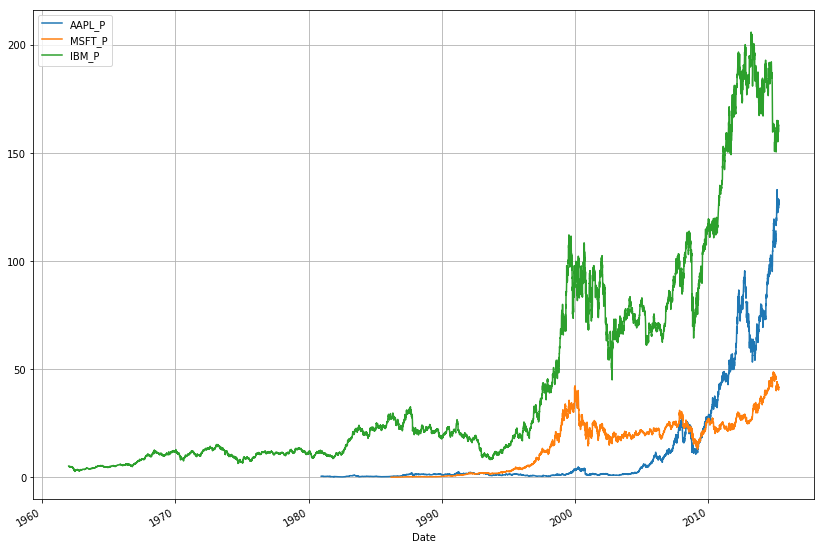

In [14]:
# plot some stocks
Diffs[['AAPL_P','MSFT_P','IBM_P']].plot(figsize=(14,10));
plt.grid()

In [15]:
Diffs.to_csv('data/SP500.csv')

In [16]:
Diffs.shape

(13422, 962)